In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


import warnings
warnings.filterwarnings("ignore")

rand_val = 5624

In [2]:
df = pd.read_csv("fit_nutri_score_classification.csv")

In [3]:
data = df[['energy-kj_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g', 
           'fiber_100g', 'fruit_vege_nut_100g', 'nutriscore_grade', 'fit_nutri_grade']].copy()

In [4]:
cluster_data = data[['energy-kj_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g', 
           'fiber_100g', 'fruit_vege_nut_100g']].copy()

In [5]:
cluster_data

,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruit_vege_nut_100g
0,1940.0,29.4,4.41,0.411,5.88,5.88,15.000000
1,1958.0,60.0,13.00,0.020,3.30,4.60,23.000000
2,1979.0,0.8,2.00,0.900,6.60,4.00,0.000000
3,1741.1,14.4,20.20,0.300,11.30,10.20,0.000000
4,1695.0,18.0,12.00,0.650,8.40,1.60,0.000000
...,...,...,...,...,...,...,...
305,1610.0,52.0,6.00,0.150,3.00,2.00,11.000000
306,2210.0,59.0,18.00,0.000,6.10,1.80,0.390625
307,1507.0,29.0,0.20,0.050,7.90,2.90,0.000000
308,2039.0,1.8,7.40,1.430,10.50,0.00,19.000000


In [6]:
rb_scaler = RobustScaler()
cluster_data = rb_scaler.fit_transform(cluster_data)

In [7]:
cluster_df = pd.DataFrame(cluster_data, columns = ['energy_kj_100g', 'sugars_100g', 'saturated_fat_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fruit_vege_nut_100g'])

In [8]:
cluster_df

,energy_kj_100g,sugars_100g,saturated_fat_100g,salt_100g,proteins_100g,fiber_100g,fruit_vege_nut_100g
0,0.061785,0.555932,0.128900,-0.106667,-0.173494,0.644156,1.012048
1,0.089245,1.593220,1.007673,-0.603175,-0.795181,0.311688,1.551807
2,0.121281,-0.413559,-0.117647,0.514286,0.000000,0.155844,0.000000
3,-0.241648,0.047458,1.744246,-0.247619,1.132530,1.766234,0.000000
4,-0.311976,0.169492,0.905371,0.196825,0.433735,-0.467532,0.000000
...,...,...,...,...,...,...,...
305,-0.441648,1.322034,0.291560,-0.438095,-0.867470,-0.363636,0.742169
306,0.473684,1.559322,1.519182,-0.628571,-0.120482,-0.415584,0.026355
307,-0.598780,0.542373,-0.301790,-0.565079,0.313253,-0.129870,0.000000
308,0.212815,-0.379661,0.434783,1.187302,0.939759,-0.883117,1.281928


In [9]:
pca = PCA(3, random_state = rand_val)
pca.fit(cluster_df)
print('\nNo. of components: ', pca.n_components_)
print(f'Total Proportion of Variance Explained = {round(np.sum(pca.explained_variance_ratio_), 3)}')

pca_cluster = pca.transform(cluster_df)
pca_cluster_df = pd.DataFrame(pca_cluster, columns = ["PC1", "PC2", "PC3"])


No. of components:  3
Total Proportion of Variance Explained = 0.787


In [10]:
dbs = DBSCAN(eps=3, min_samples=3)
pca_cluster_df['dbs_cluster'] = dbs.fit_predict(pca_cluster_df[["PC1", "PC2", "PC3"]])


In [11]:
data = data.merge(
    pca_cluster_df,
    left_index=True,
    right_index=True
)

In [12]:
pca_cluster_df_outlier = pca_cluster_df.loc[pca_cluster_df.dbs_cluster == -1]
pca_cluster_df_normal = pca_cluster_df.loc[pca_cluster_df.dbs_cluster == 0]

data_outlier = data.loc[data.dbs_cluster == -1]
data_normal = data.loc[data.dbs_cluster == 0]

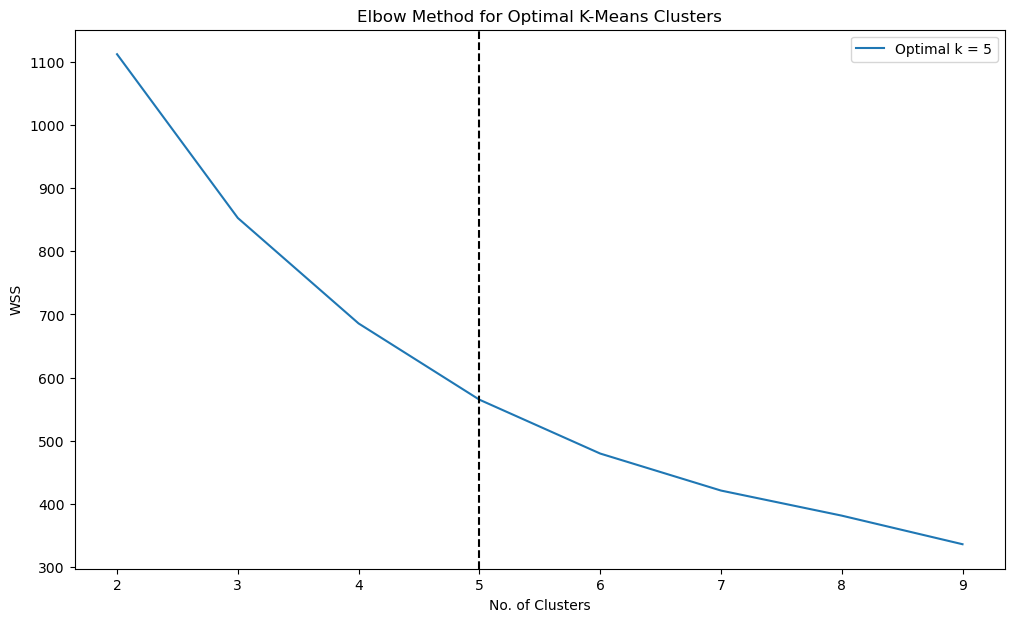

In [13]:

wss = []

max_k = 10

for k in range(2, max_k):
    kmeans = KMeans(n_clusters = k, random_state = rand_val, n_init="auto")
    kmeans.fit(pca_cluster_df_normal[["PC1", "PC2", "PC3"]])
    wss.append(kmeans.inertia_)
    
kl = KneeLocator(range(2, max_k), wss, curve = 'convex', direction = 'decreasing')
elbow = kl.elbow

plt.figure(figsize = (12, 7))
plt.plot(range(2, max_k), wss, label = f'Optimal k = {elbow}')
plt.xticks(range(2, max_k))
plt.axvline(x = elbow, color = 'black', linestyle = '--')
plt.title('Elbow Method for Optimal K-Means Clusters')
plt.xlabel("No. of Clusters")
plt.ylabel("WSS")
plt.legend()
plt.show()

In [14]:
kmeans_model = KMeans(n_clusters = 5, random_state = rand_val, n_init="auto")
pca_cluster_df_normal['km_cluster'] = kmeans_model.fit_predict(pca_cluster_df_normal[["PC1", "PC2", "PC3"]])

gmm = GaussianMixture(n_components=5, random_state=rand_val)
pca_cluster_df_normal['gmm_cluster'] = gmm.fit_predict(pca_cluster_df_normal[["PC1", "PC2", "PC3"]])

In [15]:
data_normal = data.merge(
    pca_cluster_df_normal[["km_cluster", "gmm_cluster"]],
    left_index=True,
    right_index=True
)

In [16]:
data_normal

,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruit_vege_nut_100g,nutriscore_grade,fit_nutri_grade,PC1,PC2,PC3,dbs_cluster,km_cluster,gmm_cluster
0,1940.0,29.4,4.41,0.411,5.88,5.88,15.000000,d,c,0.080618,-0.104240,-0.518184,0,3,3
1,1958.0,60.0,13.00,0.020,3.30,4.60,23.000000,e,e,-0.351203,0.352029,-1.303482,0,0,3
2,1979.0,0.8,2.00,0.900,6.60,4.00,0.000000,b,b,-0.500959,-0.945319,0.171280,0,0,0
3,1741.1,14.4,20.20,0.300,11.30,10.20,0.000000,d,d,1.190483,-1.166057,0.503403,0,3,3
4,1695.0,18.0,12.00,0.650,8.40,1.60,0.000000,e,e,-1.067297,-0.710387,0.383807,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,1610.0,52.0,6.00,0.150,3.00,2.00,11.000000,d,e,-1.122261,-0.162411,-1.231375,0,0,3
306,2210.0,59.0,18.00,0.000,6.10,1.80,0.390625,e,e,-1.228570,-0.849080,-0.314635,0,0,0
307,1507.0,29.0,0.20,0.050,7.90,2.90,0.000000,c,b,-0.710292,-0.632461,-0.237815,0,0,0
308,2039.0,1.8,7.40,1.430,10.50,0.00,19.000000,e,d,-1.073492,0.577145,1.279646,0,0,3


In [17]:
fig = px.scatter_3d(data_normal, x='PC1', y='PC2', z='PC3',
              color='km_cluster')
fig.show()

In [18]:
fig = px.scatter_3d(data_normal, x='PC1', y='PC2', z='PC3',
              color='gmm_cluster')
fig.show()

In [19]:
data_normal.km_cluster.value_counts()

km_cluster
0    165
3     92
2     27
1     14
4      5
Name: count, dtype: int64

In [20]:
data_normal.gmm_cluster.value_counts()

gmm_cluster
0    158
3     90
2     27
1     22
4      6
Name: count, dtype: int64

In [21]:
data_outlier["km_cluster"] = data_outlier["dbs_cluster"]
data_outlier["gmm_cluster"] = data_outlier["dbs_cluster"]

data_normal.drop(columns=["dbs_cluster"], inplace = True)
data_outlier.drop(columns=["dbs_cluster"], inplace = True)

final_data = pd.concat([data_normal, data_outlier])

In [22]:
final_data

,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruit_vege_nut_100g,nutriscore_grade,fit_nutri_grade,PC1,PC2,PC3,km_cluster,gmm_cluster
0,1940.0,29.40,4.41,0.411,5.88,5.88,15.000000,d,c,0.080618,-0.104240,-0.518184,3,3
1,1958.0,60.00,13.00,0.020,3.30,4.60,23.000000,e,e,-0.351203,0.352029,-1.303482,0,3
2,1979.0,0.80,2.00,0.900,6.60,4.00,0.000000,b,b,-0.500959,-0.945319,0.171280,0,0
3,1741.1,14.40,20.20,0.300,11.30,10.20,0.000000,d,d,1.190483,-1.166057,0.503403,3,3
4,1695.0,18.00,12.00,0.650,8.40,1.60,0.000000,e,e,-1.067297,-0.710387,0.383807,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,995.0,0.00,0.20,0.000,0.00,96.00,0.000000,a,b,21.930169,-6.921935,-5.683486,-1,-1
79,814.0,0.00,0.20,0.000,0.00,44.70,0.045000,a,b,9.265697,-3.567089,-3.724684,-1,-1
157,2644.0,0.00,15.90,3.000,46.30,0.00,0.000000,e,e,0.452227,0.598737,9.825860,-1,-1
171,435.0,5.75,0.50,0.930,1.05,2.60,173.171875,a,a,1.243786,10.118040,-3.035851,-1,-1


In [23]:
km_s_score = silhouette_score(final_data[["PC1", "PC2", "PC3"]], final_data["km_cluster"], metric='euclidean')
gmm_s_score = silhouette_score(final_data[["PC1", "PC2", "PC3"]], final_data["gmm_cluster"], metric='euclidean')

print(km_s_score)
print(gmm_s_score)

0.3131140539642385
0.26845327066283375


In [24]:
km_ch_score = calinski_harabasz_score(final_data[["PC1", "PC2", "PC3"]], final_data["km_cluster"])
gmm_ch_score = calinski_harabasz_score(final_data[["PC1", "PC2", "PC3"]], final_data["gmm_cluster"])

print(km_ch_score)
print(gmm_ch_score)

87.00988201328079
77.3499720592954


In [25]:
km_db_score = davies_bouldin_score(final_data[["PC1", "PC2", "PC3"]], final_data["km_cluster"])
gmm_db_score = davies_bouldin_score(final_data[["PC1", "PC2", "PC3"]], final_data["gmm_cluster"])

print(km_db_score)
print(gmm_db_score)

1.4561491734838938
1.5253517465525377


In [26]:
def check_cluster_proportions(df, cluster_col, grade_col):
    # Calculate proportions
    proportions = df.groupby([cluster_col, grade_col]).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0).reset_index()
    # Reshape data to long format
    proportions_long = pd.melt(proportions, id_vars=cluster_col, var_name=grade_col, value_name='proportion')

    custom_color_scale = {'a': 'teal', 'b': '#C5E8B7', 'c': 'orange', 'd': 'pink', 'e': 'maroon'}

    fig = px.bar(proportions_long,
                x=cluster_col,
                y='proportion',
                color=grade_col,
                title='Proportion Stacked Bar Chart',
                labels={'proportion': 'Proportion'},
                height=500,
                width= 700,
                color_discrete_map=custom_color_scale,
    )
    fig.show()


In [27]:
check_cluster_proportions(final_data.copy(), "km_cluster", "nutriscore_grade")

In [29]:
check_cluster_proportions(final_data.copy(), "km_cluster", "fit_nutri_grade")